In [1]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(adoptr)


Attaching package: ‘adoptr’


The following object is masked from ‘package:dplyr’:

    n




In [2]:
datadist   <- Normal(two_armed = TRUE)
h0         <- PointMassPrior(.0, 1) # second value is the probability mass
h1         <- PointMassPrior(.2, 1)

alpha      <- 0.05
beta       <- 0.2

In [3]:
ess   <- ExpectedSampleSize(datadist, h1)
power <- Power(datadist, h1)
toer  <- Power(datadist, h0)

In [4]:
# guess group sequential initial design to refine
initial_design <- get_initial_design(
    theta = .2,
    alpha = alpha,
    beta  = beta,
    type  = "two-stage",
    dist  = datadist,
    order = 7L
)

In [5]:
res <- minimize(
  
    ess,

    subject_to(
        power >= 1 - beta,
        toer  <= alpha
    ),

    initial_design
)

design <- res$design

In [6]:
summary(design, ESS = ess, Power = power, MTOER = toer)

TwoStageDesign: n1 = 173 
          futility |                  continue                 | efficacy
      x1:     0.50 |  0.54  0.69  0.94  1.25  1.55  1.80  1.95 |  1.99
  c2(x1):     +Inf | +1.99 +1.86 +1.62 +1.29 +0.89 +0.45 +0.03 |  -Inf
  n2(x1):        0 |   258   245   221   186   145   104    71 |     0
     ESS:    250.209
   Power:      0.801
   MTOER:      0.050


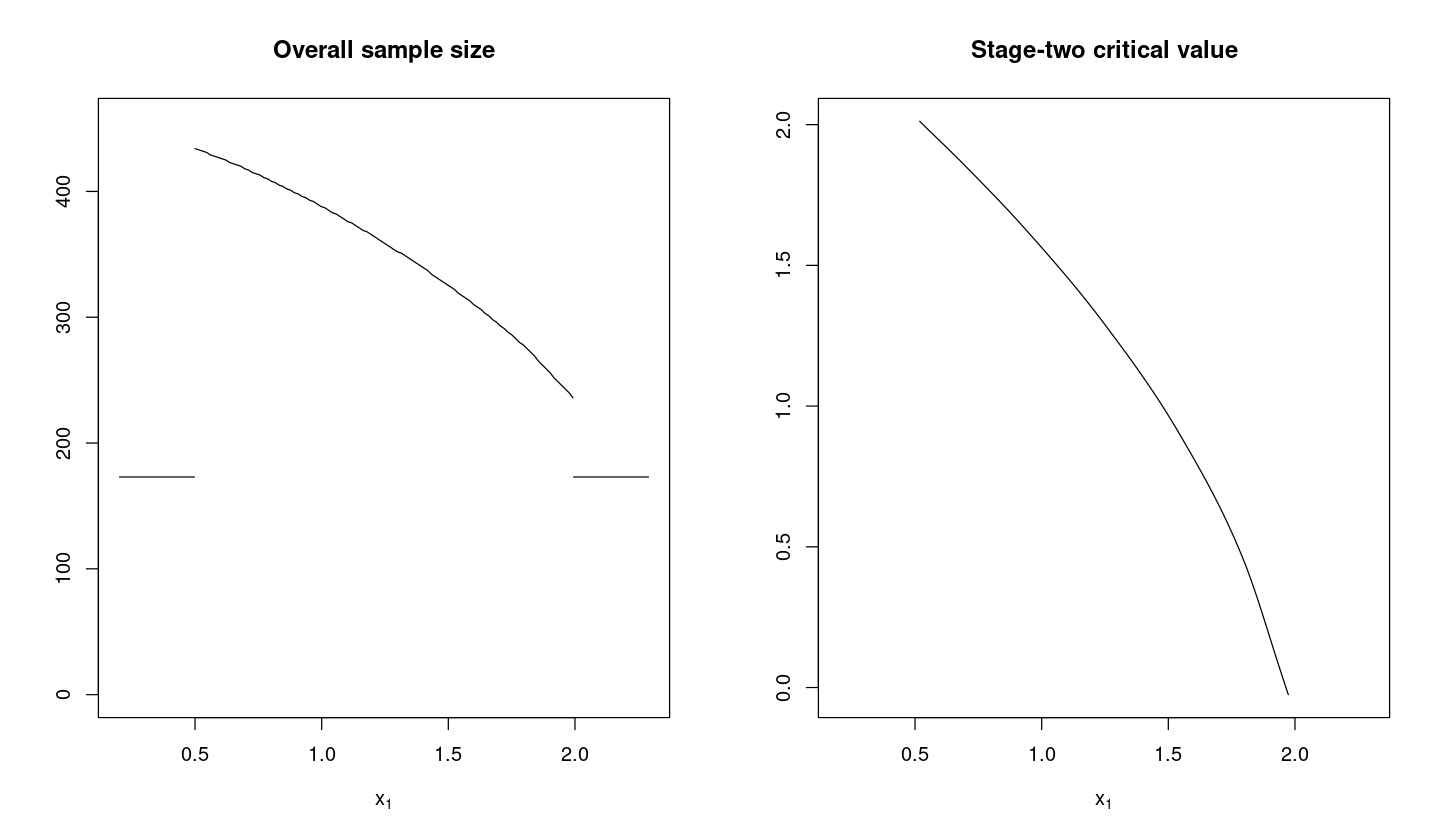

In [7]:
options(repr.plot.width = 12, repr.plot.height = 7)


plot(design)

In [18]:
res0 <- minimize(
  
    ExpectedSampleSize(datadist, h0),

    subject_to(
        power >= 1 - beta,
        toer  <= alpha
    ),

    get_initial_design(
        theta = .2,
        alpha = alpha,
        beta  = beta,
        type  = "two-stage",
        dist  = datadist,
        order = 5L
    ),
    
    opts = list(algorithm = "NLOPT_LN_COBYLA", xtol_rel = 1e-05, maxeval = 1e5),
)

design0 <- res0$design

In [19]:
summary(design0, ESS = ess, Power = power, MTOER = toer)

TwoStageDesign: n1 = 120 
          futility |            continue           | efficacy
      x1:     0.39 |  0.53  1.08  1.88  2.69  3.24 |  3.38
  c2(x1):     +Inf | +1.29 +1.05 +0.83 +0.65 +0.53 |  -Inf
  n2(x1):        0 |   132   234   352   454   513 |     0
     ESS:    388.580
   Power:      0.800
   MTOER:      0.050


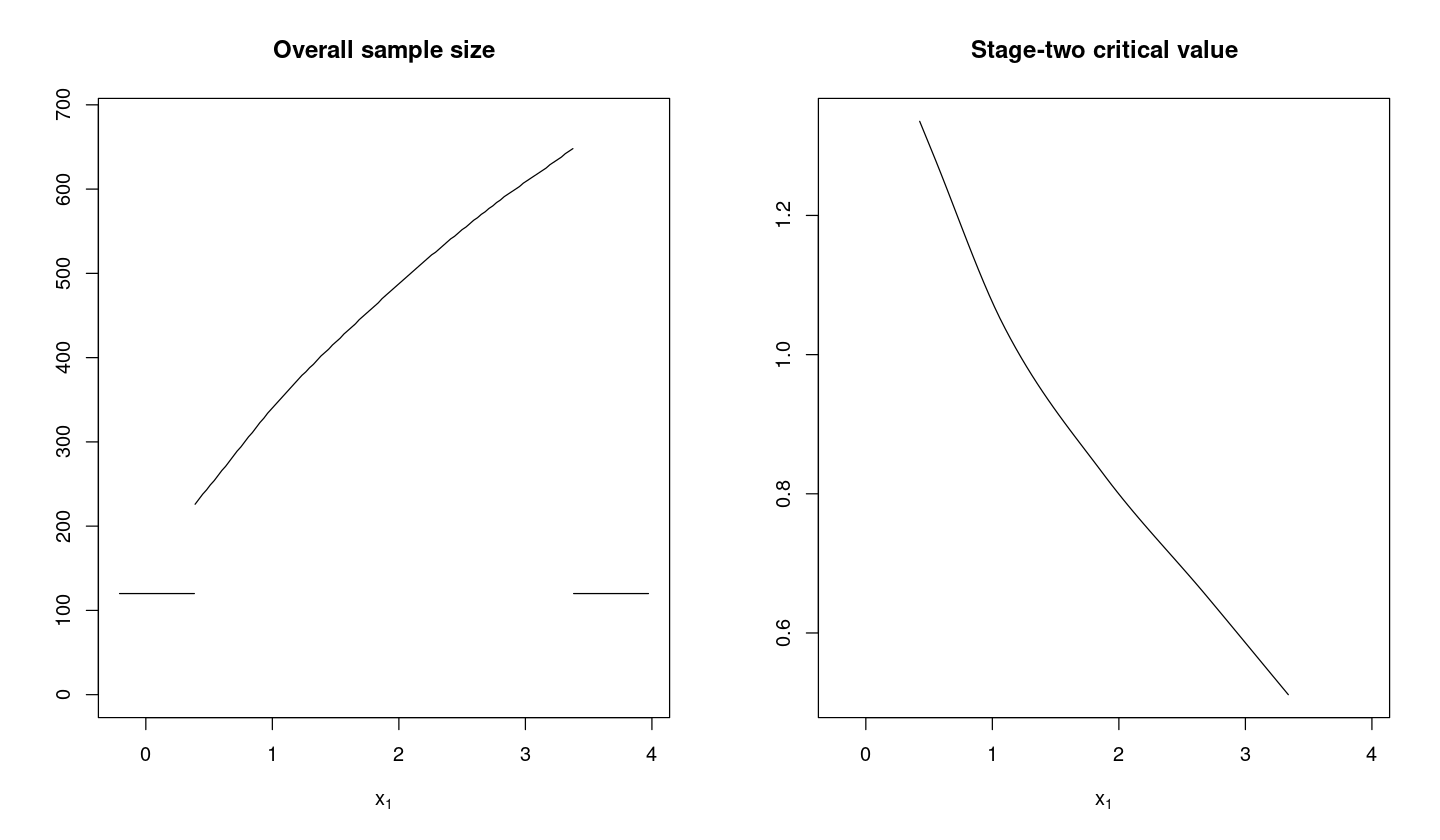

In [20]:
plot(design0)

In [26]:
resb <- minimize(
  
    ExpectedSampleSize(datadist, ContinuousPrior(pdf = function(theta) dnorm(theta, mean = .1, sd = .1), support = c(-1, 1), order   = 25)),

    subject_to(
        power >= 1 - beta,
        toer  <= alpha
    ),

    design,
    
    opts = list(algorithm = "NLOPT_LN_COBYLA", xtol_rel = 1e-05, maxeval = 1e5),
)

designb <- resb$design

In [27]:
summary(designb, ESS = ess, ESS2 = ExpectedSampleSize(datadist, ContinuousPrior(pdf = function(theta) dnorm(theta, mean = .1, sd = .1), support = c(-1, 1), order   = 25)), Power = power, MTOER = toer)

TwoStageDesign: n1 = 157 
          futility |                  continue                 | efficacy
      x1:     0.58 |  0.62  0.77  1.02  1.32  1.62  1.87  2.03 |  2.07
  c2(x1):     +Inf | +1.68 +1.56 +1.37 +1.13 +0.82 +0.47 +0.15 |  -Inf
  n2(x1):        0 |   177   203   224   226   206   171   137 |     0
     ESS:    257.597
    ESS2:    239.269
   Power:      0.800
   MTOER:      0.050


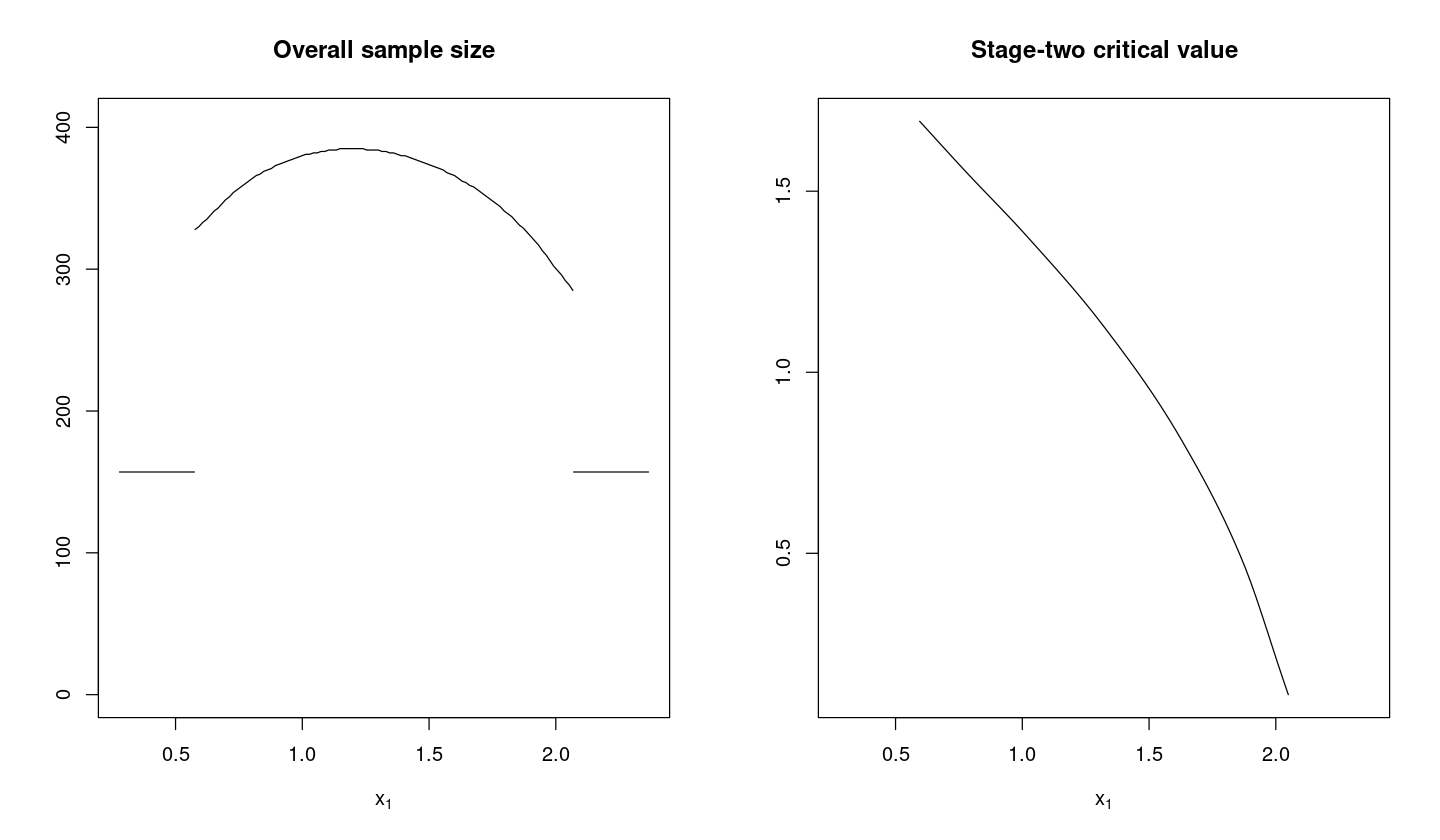

In [28]:
plot(designb)

In [70]:
tbl_designs <- tibble(
    name = c("alternative", "null", "Bayesian"),
    design = list(design, design0, designb)
)

In [71]:
plt_power <- expand_grid(
    theta = seq(-.1, .5, by = .01),
    tbl_designs
) %>% 
mutate(
    Power = map2_dbl(theta, design, ~evaluate(Power(datadist, PointMassPrior(.x, 1.0)), .y))
)  %>% {
ggplot(.) + 
    aes(theta, Power, color = name) +
    geom_line() +
    scale_x_continuous(expression(theta)) + 
    scale_y_continuous("Power", breaks = seq(0, 1, .2)) + 
    scale_color_discrete("") +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

In [72]:
plt_n <- expand_grid(
    x1 = seq(0, 3.5, by = .01),
    tbl_designs
) %>% 
mutate(
    n = map2_dbl(x1, design, ~n(.y, .x)),
    n = pmap_dbl(list(x1, design, n), ~ifelse(abs(..1 - ..2@c1f) <= .01, NA, ..3)),
    n = pmap_dbl(list(x1, design, n), ~ifelse(abs(..1 - ..2@c1e) <= .01, NA, ..3))
) %>% {
ggplot(.) + 
    aes(x1, n, color = name) +
    geom_line() +
    scale_x_continuous(expression(x[1])) + 
    scale_y_continuous(expression(n(x[1])), limits = c(0, NA)) + 
    scale_color_discrete("") +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

In [73]:
plt_c2 <- expand_grid(
    x1 = seq(0, 3.5, by = .01),
    tbl_designs
) %>% 
mutate(
    c2 = map2_dbl(x1, design, ~c2(.y, .x)),
    c2 = ifelse(!is.finite(c2), NA, c2)
) %>% {
ggplot(.) + 
    aes(x1, c2, color = name) +
    geom_line() +
    scale_x_continuous(expression(x[1])) + 
    scale_y_continuous(expression(c[2](x[1]))) + 
    scale_color_discrete("") +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

In [74]:
plt_ess <- expand_grid(
    theta = seq(-.1, .5, by = .01),
    tbl_designs
) %>% 
mutate(
    ess = map2_dbl(theta, design, ~evaluate(ExpectedSampleSize(datadist, PointMassPrior(.x, 1.0)), .y))
) %>% {
ggplot(.) + 
    aes(theta, ess, color = name) +
    geom_line() +
    scale_x_continuous(expression(theta)) + 
    scale_y_continuous("Expected sample size", limits = c(0, NA)) + 
    scale_color_discrete("") +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

Warning message:
“Removed 456 row(s) containing missing values (geom_path).”


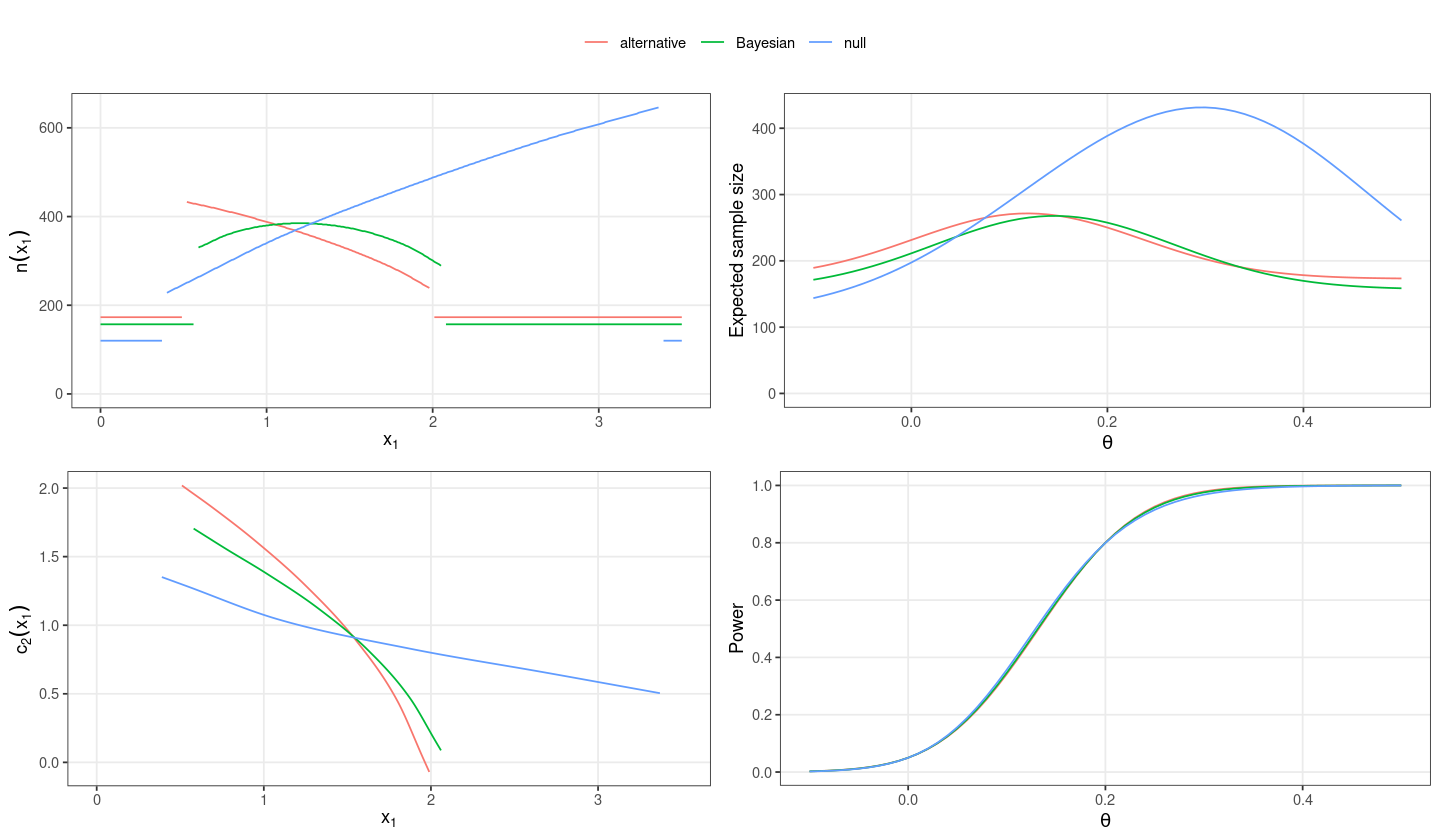

In [75]:
cowplot::plot_grid(
    cowplot::get_legend(plt_n + theme(legend.position = "top")),
    cowplot::plot_grid(
        plt_n + theme(legend.position="none"), plt_ess + theme(legend.position="none"), plt_c2 + theme(legend.position="none"), plt_power + theme(legend.position="none")
    ),
    ncol = 1,
    rel_heights = c(.1, .9)
)

In [76]:
ggsave("continuous-case-design.pdf", width = 7, height = 6.5)